<center><h1>KIM_GUK IL_HW6</h1></center>

Name: GUK IL KIM 
<br>
Github Username: DanielKim12 
<br>
USC ID: 3020867072

## 1. Tree-Based Methods

Import packages

In [83]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import math 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, KFold
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

### (a) Download the APS Failure data

In [9]:
test = "./data/aps_failure_test_set.csv"
train = "./data/aps_failure_training_set.csv"
# method used from hw 5 
# na_values = 'na' is used to replace all na values with np.nan
df_train = pd.read_csv(train, skiprows=20, na_values = 'na')
df_test = pd.read_csv(test, skiprows=20, na_values = 'na')
df_train = df_train.replace({'neg': 0, 'pos': 1, 'na':np.nan})
df_test = df_test.replace({'neg': 0, 'pos': 1, 'na':np.nan})
print("train shape: ", df_train.shape)
print("test shape: ", df_test.shape)
df_train_x = df_train.iloc[:, 1:]
df_train_y = df_train.iloc[:, 0]
df_test_x = df_test.iloc[:, 1:]
df_test_y = df_test.iloc[:, 0]

train shape:  (60000, 171)
test shape:  (16000, 171)


In [13]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df_train_x_imputed = pd.DataFrame(imputer.fit_transform(df_train_x), columns = df_train.columns[1:])
df_test_x_imputed = pd.DataFrame(imputer.transform(df_test_x), columns=df_test_x.columns)

### (b) Data Preparation

#### (i) Research what types of techniques are usually used

There are 4 different types of techniques we can use: 
1. replacing missing values with the column's mean or median, ideal for numeric data.
2. using similar data points to predict missing values, capturing relationships between varaibles. 
3. imputing values, pooling results fr accuracy, this method can be useful in complex datasets. 
4. filling missing values with most frequent value or a specific constant. 

I have selected the first method of imputating mean. 

#### (ii) Calculate the coefficient of variation

In [167]:
cv = {}
for col in df_train_x_imputed.columns:
    mu = df_train_x_imputed[col].mean()
    sigma = df_train_x_imputed[col].std()
    # avoid division by zero
    cv[col] = [mu, sigma, sigma / mu if mu != 0 else np.nan] 

coefficient_of_variation = pd.DataFrame(cv)
coefficient_of_variation.index = ['mean', 'std', 'cv']
coefficient_of_variation

aa_000    ab_000        ac_000        ad_000      ae_000  \
mean   59336.499567  0.713189  3.560143e+08  1.906206e+05    6.819130   
std   145430.056532  1.660588  7.724678e+08  3.504515e+07  158.142022   
cv         2.450938  2.328400  2.169767e+00  1.838476e+02   23.190937   

          af_000        ag_000        ag_001         ag_002         ag_003  \
mean   11.006817    221.636367    975.722261    8606.014529   88591.281094   
std   205.375337  20363.631242  34008.750683  149479.100501  757459.796689   
cv     18.658921     91.878565     34.854950      17.369143       8.550049   

      ...        ee_002         ee_003        ee_004        ee_005  \
mean  ...  4.454897e+05  211126.447302  4.457343e+05  3.939462e+05   
std   ...  1.149060e+06  540272.166338  1.161763e+06  1.114758e+06   
cv    ...  2.579319e+00       2.558998  2.606402e+00  2.829722e+00   

            ee_006        ee_007         ee_008        ee_009     ef_000  \
mean  3.330582e+05  3.462714e+05  138729.983179   8388.914629   0.090579   
std   1.063164e+06  1.718366e+06  446989.425928  47204.242869   4.268529   
cv    3.192128e+00  4.962483e+00       3.222010      5.626979  47.124953   

         eg_000  
mean   0.212756  
std    8.627929  
cv    40.553250  

[3 rows x 170 columns]

#### (iii) Plot a correlation matrix

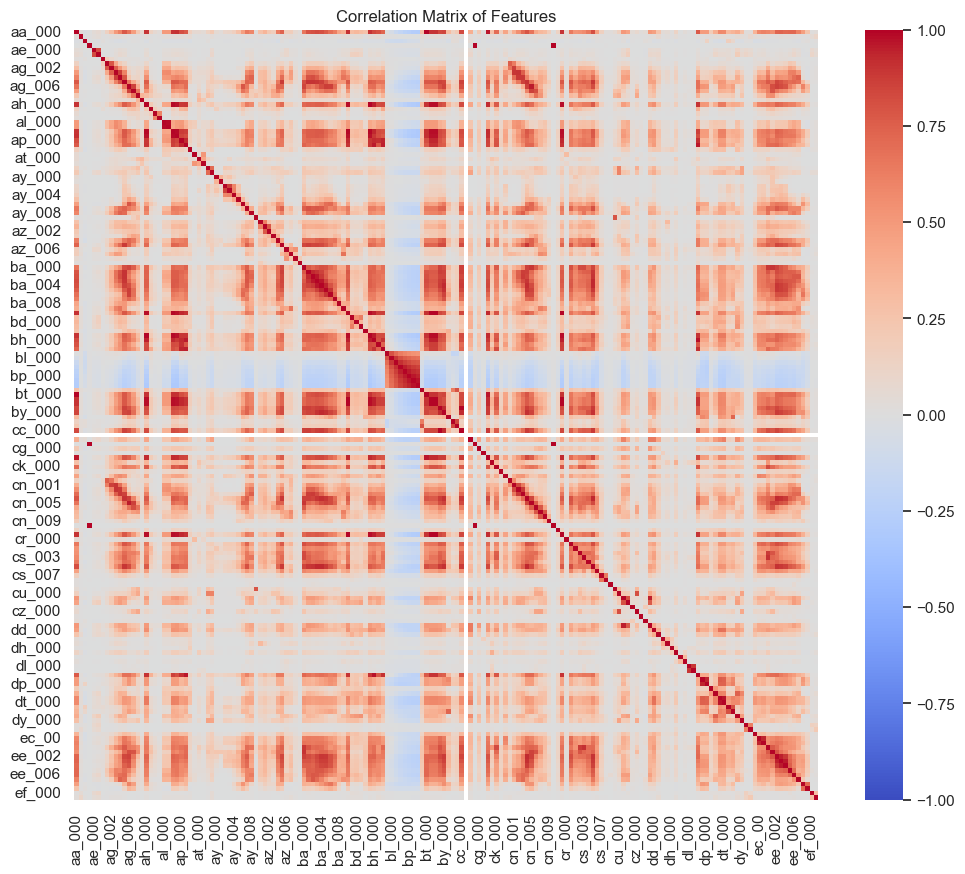

In [171]:
corr_matrix = df_train_x_imputed.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Features")
plt.show()

In [172]:
correlation = df_train_x_imputed.corr()
correlation.style.background_gradient(cmap = 'coolwarm')

#### (iv) Make scatter plots and box plots

Index(['cs_009', 'cf_000', 'co_000', 'ad_000', 'dh_000', 'dj_000', 'ag_000',
       'as_000', 'ay_009', 'az_009', 'ak_000', 'au_000', 'ch_000'],
      dtype='object')


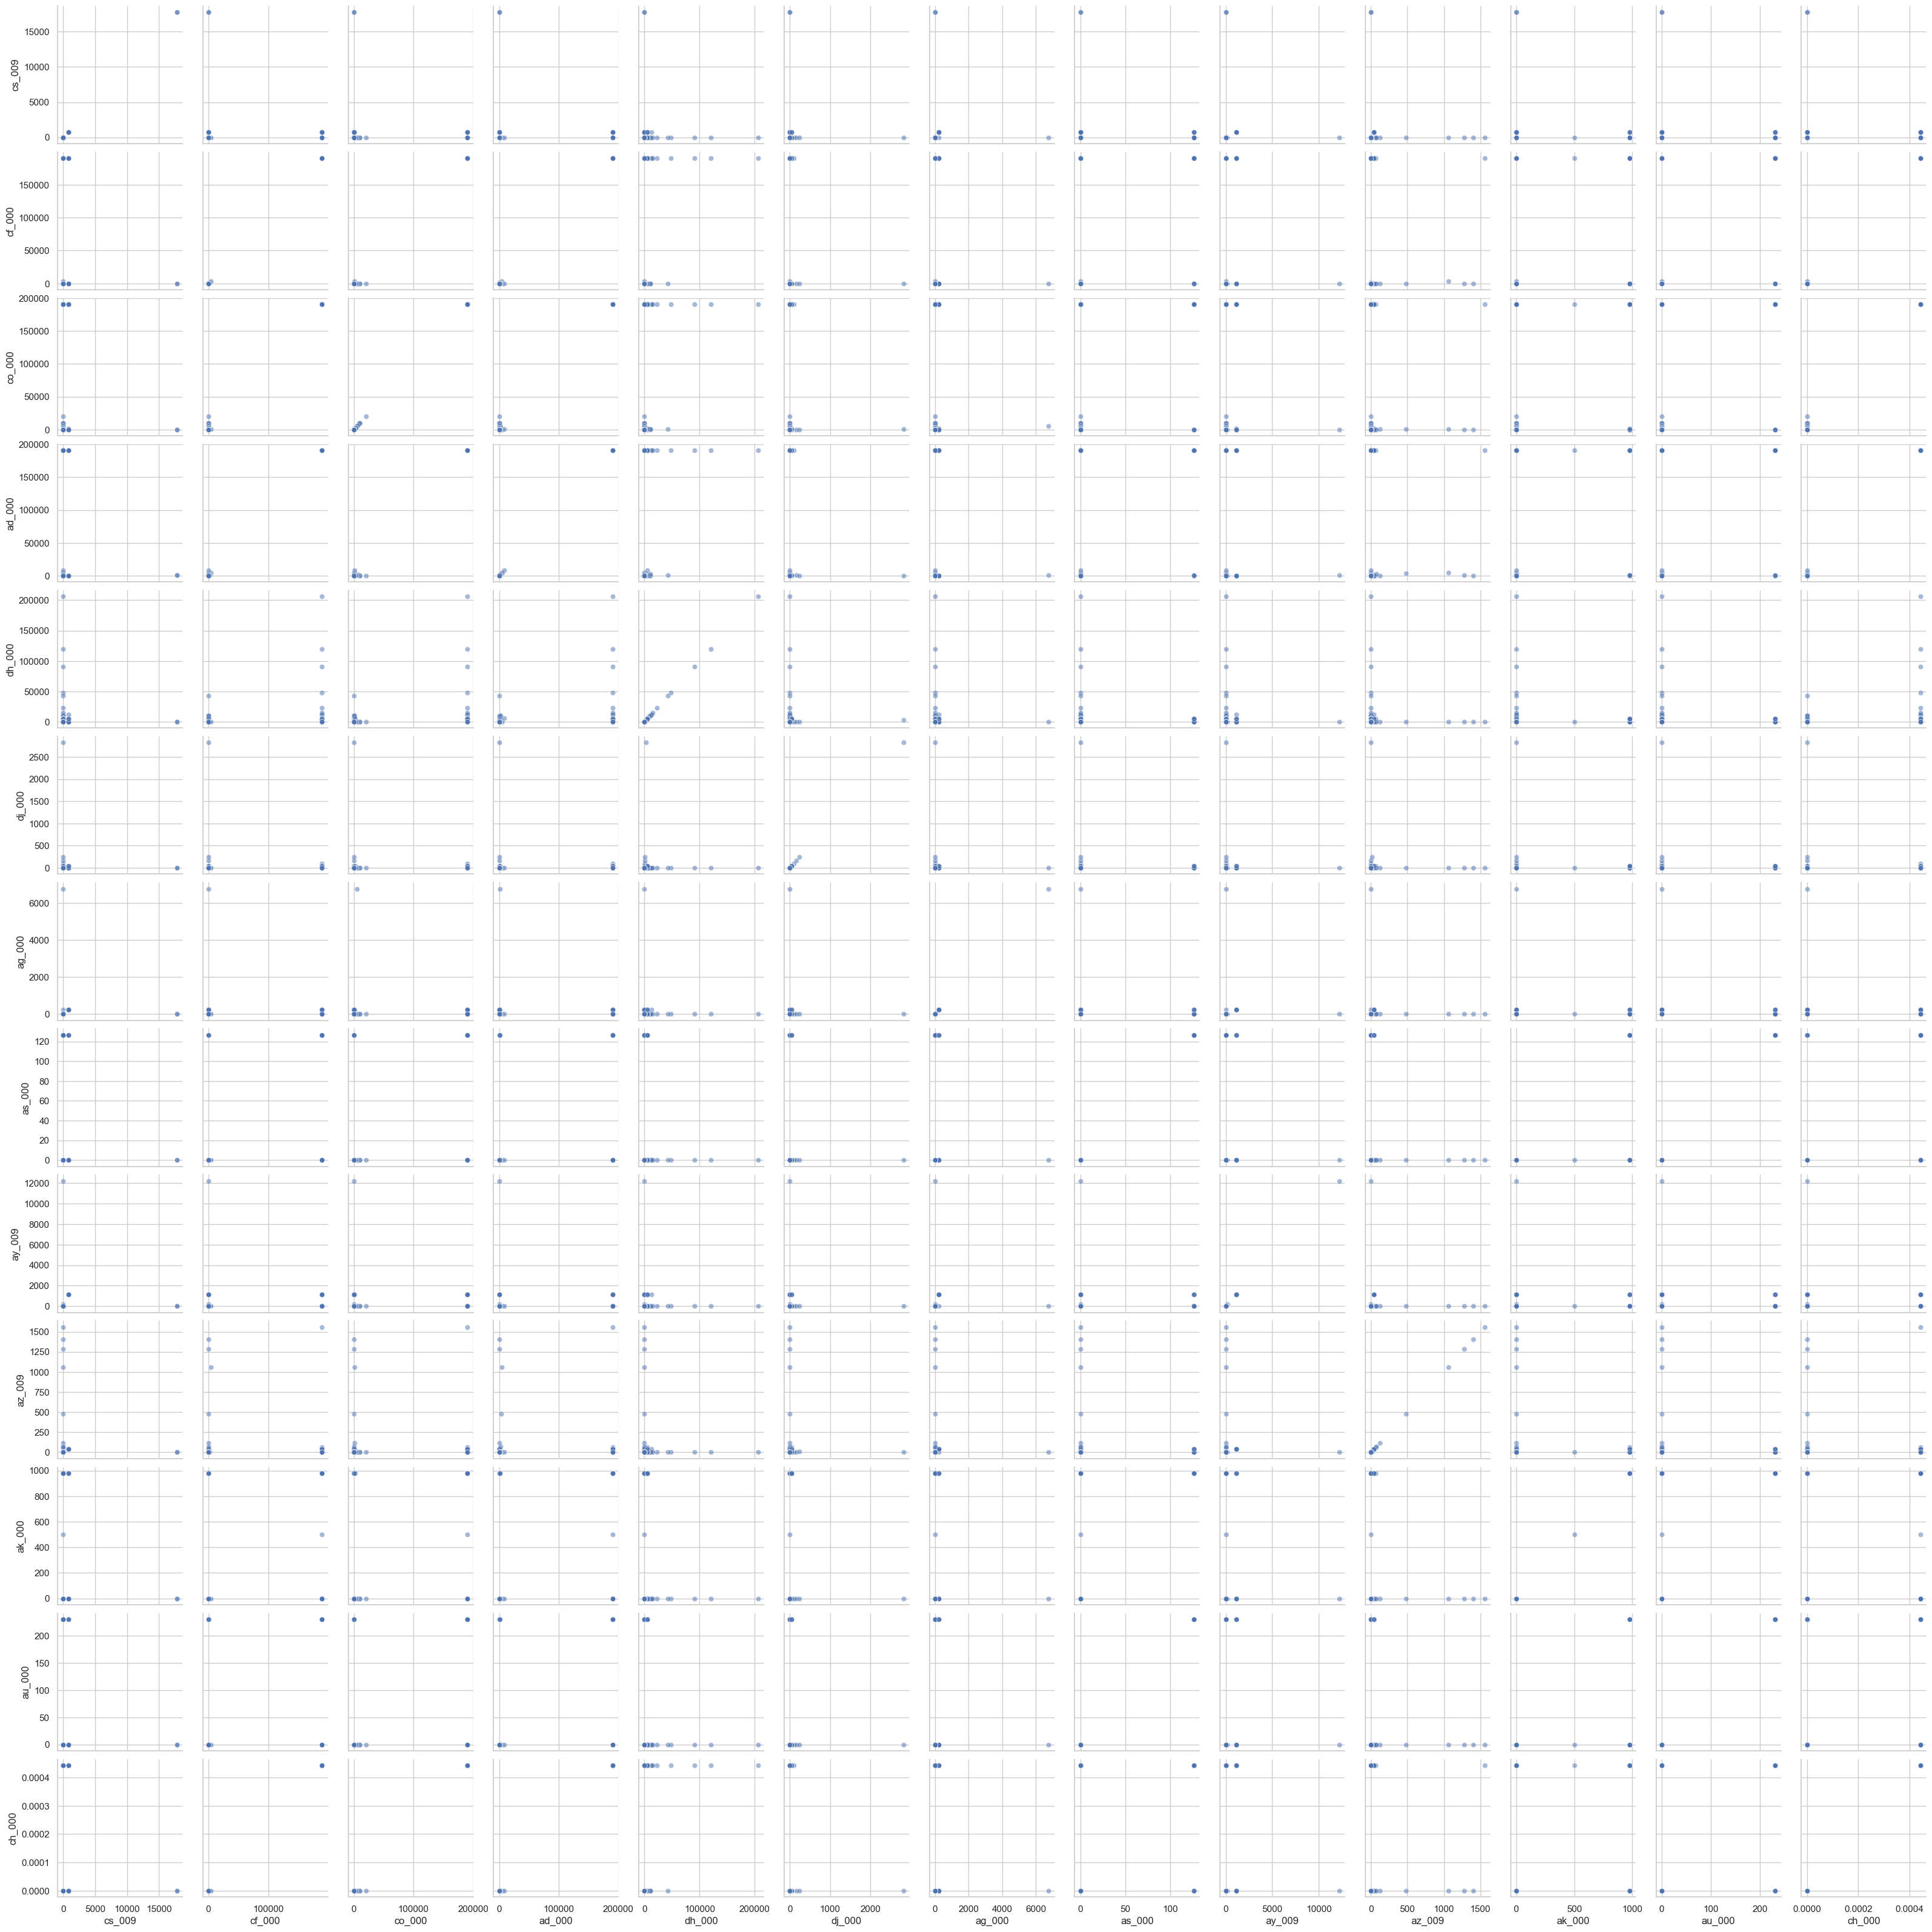

In [181]:
index = np.argsort(coefficient_of_variation.iloc[2])[::-1][:math.floor(math.sqrt(170))] #square root of 170
selected_col = df_train_x_imputed.columns[index]
print(selected_col)
pairplot = sns.pairplot(data=df_train_x_imputed[selected_col].sample(1000), diag_kind=None, plot_kws={'alpha': 0.5})

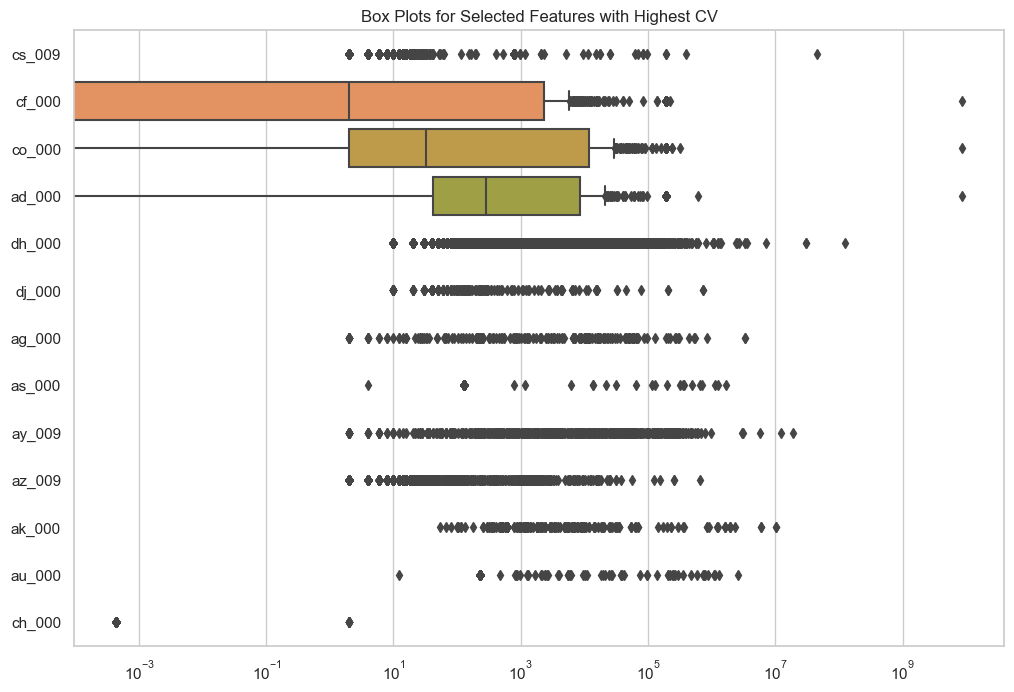

In [116]:
plt.figure(figsize=(12, 8))
# Creating horizontal box plots with log scale for the x-axis
box = sns.boxplot(data=df_train_x_imputed[selected_col], orient='h')
box.set(xscale="log")
box.set_title("Box Plots for Selected Features with Highest CV")
plt.show()

### conclusion: 
Just by looking at scatterplot, we can see that most features are clustered around lower values with high value outliers. Thus as I am using mean imputation there can be variabilty in sensivity for model training. scaling can make model more stable. 

#### (v) Is this data set imbalanced?

In [34]:
# Count the occurrences of each class in the target column
class_counts = df_train['class'].value_counts()
print("Class distribution:")
print(class_counts)

Class distribution:
0    59000
1     1000
Name: class, dtype: int64


### observation:
From above we can see that the dataset is highly mbalanced with only 1000 positive samples (labeled as 1) and 59,000 negative samples (labeled as 0). Thus the ratio of positive sample in this dataset is 1.67%. 

### (c) Train a random forest

In [127]:
def analysis(y_true, y_pred, y_proba, title, pos_label=1, is_xgboost=False):
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(f'Confusion Matrix for {title}:\n{conf_matrix}\n')
    # Accuracy and Error
    accuracy = round(accuracy_score(y_true, y_pred), 5)
    error = round(1 - accuracy, 5)
    print(f'Accuracy: {accuracy}')
    print(f'Error: {error}')
    # ROC AUC Score (For XGBoost only, if specified)
    if is_xgboost:
        roc_auc = round(roc_auc_score(y_true, y_pred), 5)
        print(f'ROC AUC Score (XGBoost): {roc_auc}')

    # Ensure y_proba is the right shape and type
    if isinstance(y_proba, np.ndarray) and y_proba.ndim == 2 and y_proba.shape[1] == 2:
        y_predicted = y_proba[:, 1]  # Select probability for the positive class
    else:
        raise ValueError("y_proba must be a 2D numpy array with shape")
    
    # Plot ROC Curve
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_title(f"ROC Curve for {title}")
    fpr, tpr, thresholds = roc_curve(y_true, y_predicted, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f"ROC AUC: {round(roc_auc, 5)}")
    ax.plot([0, 1], [0, 1], "--", color="red")  
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    plt.show()

    # Return summary data
    data = {'conf_matrix': conf_matrix, 'accuracy': accuracy, 'error': error, 'roc_auc': roc_auc}
    if is_xgboost:
        data['roc_auc_xgboost'] = roc_auc
    return data


Confusion Matrix for Training:
[[58972    28]
 [  450   550]]

Accuracy: 0.99203
Error: 0.00797


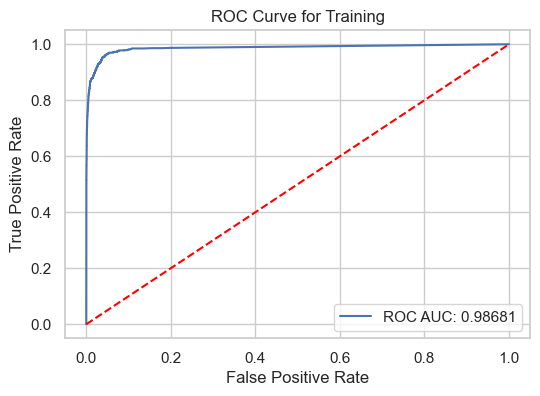

In [128]:
y_train = df_train_y
x_train = df_train_x_imputed

# not balancing classes
is_balanced = False  
if is_balanced:
    clf = RandomForestClassifier(max_depth=5, random_state=60000, oob_score=True, class_weight='balanced')
else:
    clf = RandomForestClassifier(max_depth=5, random_state=60000, oob_score=True)

clf.fit(x_train, y_train)
y_train_pred = clf.predict(x_train)
y_train_proba = clf.predict_proba(x_train)
_ = analysis(y_train, y_train_pred, y_train_proba, "Training")

Confusion Matrix for Testing:
[[15612    13]
 [  178   197]]

Accuracy: 0.98806
Error: 0.01194


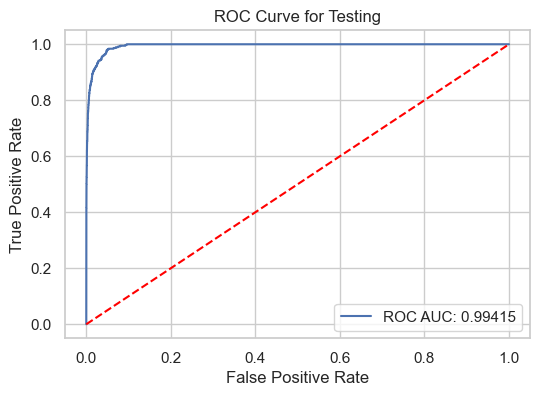

In [129]:
# for test set
y_test = df_test_y  
x_test = df_test_x_imputed  
y_test_pred = clf.predict(x_test)
y_test_proba = clf.predict_proba(x_test)
_ = analysis(y_test, y_test_pred, y_test_proba, "Testing")

In [130]:
clf = RandomForestClassifier(max_depth=5, random_state=42, oob_score=True)
clf.fit(x_train, y_train)

# Retrieve the OOB error
oob_error = 1 - clf.oob_score_
print(f"OOB Error: {oob_error:.4f}")
# test error
y_test_pred = clf.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy
print(f"Test Error: {test_error:.4f}")

OOB Error: 0.0093
Test Error: 0.0117


### Observation: 
In comparison Test error has about 20.51% more errors than OOb errors. As seen from the imbalance in dataset, fewer positive data points the model leads to model's focus on the negative class increases false negatives, raising test error above training error.

### (d) Research class imbalance in random forest

1. using **class_weight='balanced'** in RandomForestClassifier, this will adjust weights inversely proportional to class frequencies to give higher weight to minority classes.
2. **BalancedRandomForestClassifier** will create balanced bootstrapped samples by undersampling the majority class
3. **SMOTE** can be used to generate synthetic data points for the minority class

Confusion Matrix for Training:
[[56563  2437]
 [   31   969]]

Accuracy: 0.95887
Error: 0.04113


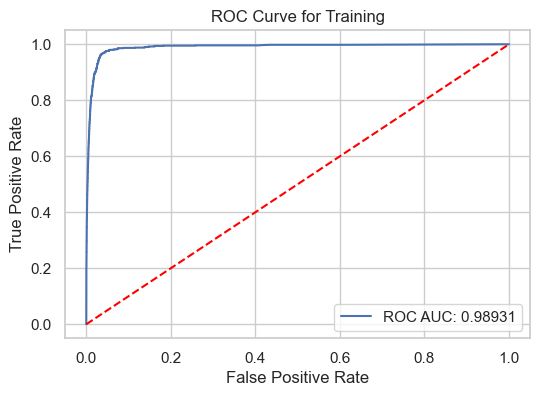

In [131]:
y_train = df_train_y
x_train = df_train_x_imputed
# balancing classes
is_balanced = True  
if is_balanced:
    clf = RandomForestClassifier(max_depth=5, random_state=60000, oob_score=True, class_weight='balanced')
else:
    clf = RandomForestClassifier(max_depth=5, random_state=60000, oob_score=True)

clf.fit(x_train, y_train)
y_train_pred = clf.predict(x_train)
y_train_proba = clf.predict_proba(x_train)
_ = analysis(y_train, y_train_pred, y_train_proba, "Training")

Confusion Matrix for Testing:
[[14994   631]
 [   15   360]]

Accuracy: 0.95962
Error: 0.04038


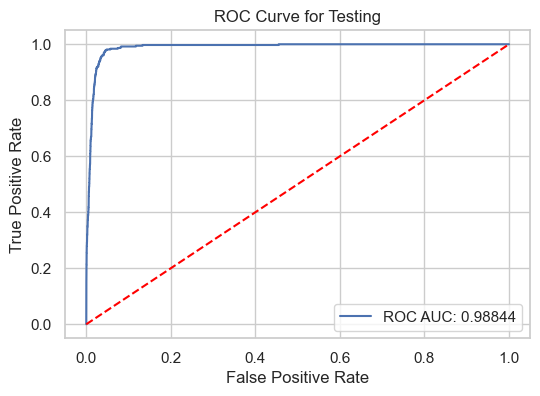

In [132]:
# test set
y_test = df_test_y  
x_test = df_test_x_imputed  
y_test_pred = clf.predict(x_test)
y_test_proba = clf.predict_proba(x_test)
_ = analysis(y_test, y_test_pred, y_test_proba, "Testing")

In [133]:
oob_error = 1 - clf.oob_score_
print(f"OOB Error: {oob_error:.4f}")

y_test_pred = clf.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy
print(f"Test Error: {test_error:.4f}")

OOB Error: 0.0424
Test Error: 0.0404


### Observation:
OOB error has about 4.72% more error than test error, though minimal difference between two errors signifies that model is well generalized and performs similariy on both training and testing data.

### Cmparing 1c and 1d:
- Imbalanced data (negative > positive) will make the model predict the negative class and give high accuracy but will perform bad for positive class.
- Balanced data, model’s performance on the positive class improves significantly.

### (e) XGBoost and Model Trees

In [138]:
# optimal hyperparameters
param_grid = {
    "reg_alpha": [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
}

scaler = StandardScaler()
# Scale the training and testing data
x_train_scaled = pd.DataFrame(scaler.fit_transform(df_train_x_imputed), columns=df_train_x_imputed.columns)
x_test_scaled = pd.DataFrame(scaler.transform(df_test_x_imputed), columns=df_test_x_imputed.columns)
print(x_train_scaled.shape)
print(x_test_scaled.shape)

(60000, 170)
(16000, 170)


In [139]:
def tune_and_train_xgboost(x_train, y_train, param_grid):
    # XGBoost classifier with base parameters
    model = XGBClassifier(objective='binary:logistic', colsample_bytree=0.3, learning_rate=0.1, max_depth=5, use_label_encoder=False)
    
    # gridcv to find the best `reg_alpha`
    # Set n_jobs=1 to avoid parallel processing issues
    gridcv = GridSearchCV(model, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring="accuracy", n_jobs=1) 
    
    # Fit grid search on the training data to find the best `reg_alpha`
    gridcv.fit(x_train, y_train)
    best_alpha = gridcv.best_params_['reg_alpha']
    print('Best alpha:', best_alpha)
    print('Best CV training accuracy:', round(gridcv.best_score_, 5))
    
    # Train the final model with the best `reg_alpha`
    final_model = XGBClassifier(objective='binary:logistic', reg_alpha=best_alpha, colsample_bytree=0.3, learning_rate=0.1, max_depth=5, use_label_encoder=False)
    final_model.fit(x_train, y_train)
    return final_model, best_alpha

# output the final model and best alpha
final_model, best_alpha = tune_and_train_xgboost(x_train_scaled, df_train_y, param_grid)

Best alpha: 0.05
Best CV training accuracy: 0.99402


Confusion Matrix for Training:
[[58998     2]
 [   98   902]]

Accuracy: 0.99833
Error: 0.00167
ROC AUC Score (XGBoost): 0.95098


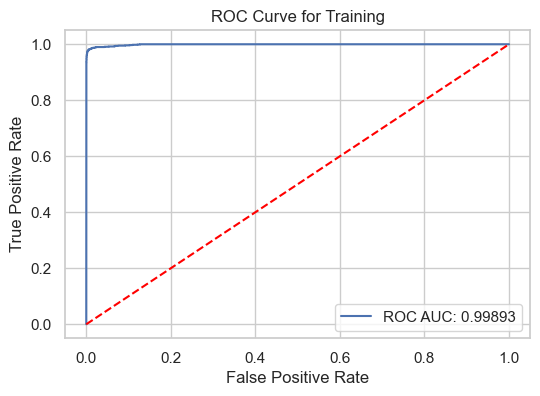

Confusion Matrix for Testing:
[[15606    19]
 [   96   279]]

Accuracy: 0.99281
Error: 0.00719
ROC AUC Score (XGBoost): 0.87139


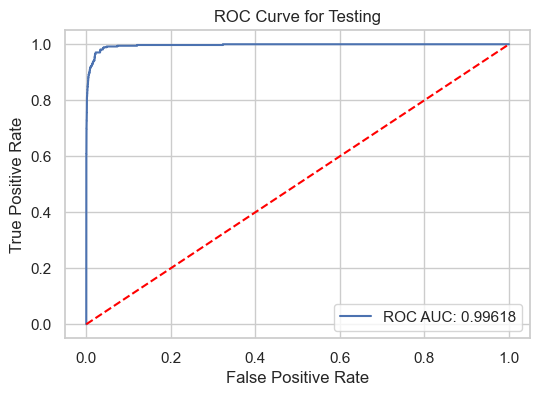

In [140]:
y_train_pred = final_model.predict(x_train_scaled)
y_train_proba = final_model.predict_proba(x_train_scaled)
y_test_pred = final_model.predict(x_test_scaled)
y_test_proba = final_model.predict_proba(x_test_scaled)

# eval the model on training and test data
train_stats = analysis(df_train_y, y_train_pred, y_train_proba, "Training", is_xgboost=True)
test_stats = analysis(df_test_y, y_test_pred, y_test_proba, "Testing", is_xgboost=True)

### (f) Use SMOTE to pre-process your data

Class distribution after SMOTE: 0    59000
1    59000
Name: class, dtype: int64
Best alpha: 0.2
Best CV training accuracy: 0.99477
The best alpha found after SMOTE: 0.2
Confusion Matrix for Training:
[[58675   325]
 [   62 58938]]

Accuracy: 0.99672
Error: 0.00328


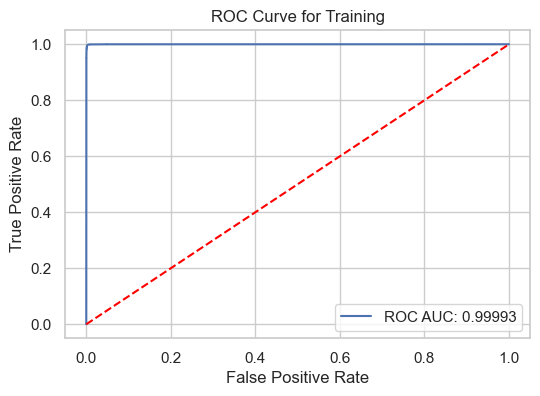

Confusion Matrix for Testing:
[[15498   127]
 [   46   329]]

Accuracy: 0.98919
Error: 0.01081


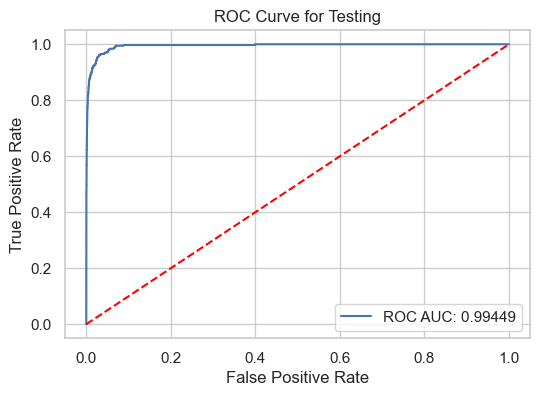

In [137]:
# smote 
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(df_train_x_imputed, df_train_y)
print("Class distribution after SMOTE:", y_train_smote.value_counts())
# tune and train xgboost with SMOTE
final_model, best_alpha = tune_and_train_xgboost(X_train_smote, y_train_smote, param_grid)
print(f'The best alpha found after SMOTE: {best_alpha}')

# eval train data 
y_train_pred = final_model.predict(X_train_smote)
y_train_proba = final_model.predict_proba(X_train_smote)
# analysis function to evaluate on training data
train_stats = analysis(y_train_smote, y_train_pred, y_train_proba, "Training")

# eval test data 
y_test_pred = final_model.predict(df_test_x_imputed)
y_test_proba = final_model.predict_proba(df_test_x_imputed)
test_stats = analysis(df_test_y, y_test_pred, y_test_proba, "Testing")


In [186]:
# hardcoded based on my stats
# Hardcoded stats with the specified order
smote_stats = {
    "Train Error": 0.00328,
    "Test Error": 0.01081,
    "Train Accuracy": 0.99672,
    "Test Accuracy": 0.98919,
    "Train ROC": 0.99993,
    "Test ROC": 0.99449
}

no_smote_stats = {
    "Train Error": 0.00167,
    "Test Error": 0.00719,
    "Train Accuracy": 0.99833,
    "Test Accuracy": 0.99281,
    "Train ROC": 0.99893,
    "Test ROC": 0.99618
}

# Create a DataFrame to compare the metrics with the specified order
comparison_df = pd.DataFrame([no_smote_stats, smote_stats], index=['Without SMOTE', 'With SMOTE'])
comparison_df

Train Error  Test Error  Train Accuracy  Test Accuracy  \
Without SMOTE      0.00167     0.00719         0.99833        0.99281   
With SMOTE         0.00328     0.01081         0.99672        0.98919   

               Train ROC  Test ROC  
Without SMOTE    0.99893   0.99618  
With SMOTE       0.99993   0.99449

## 2. ISLR 6.6.3

- a. **Steadily decrease**, starting from 0, we begin with the least flexible, most restricted model and end with the least squares model. As the model becomes more flexible, the training RSS will steadily decrease.
- b. **Decrease at first and then increase**, for the test RSS, it will initially decrease and then start increasing as the model becomes more flexible and begins to overfit the training data.
- c. **Steadily increase**, starting from zero, we begin with the least flexible, most restricted model and end with the least squares model. As flexibility increases, variance will always steadily increase.
- d. **Steadily decrease**, the squared bias will steadily decrease as model flexibility increases.
- e. **Irreducible error**, the irreducible error remains constant and is independent of the model. 

## 3. ISLR 6.6.5

- a) given above, $x_{11} = x_{12} = x_1$ and $x_{11} = x_{12} = x_2$, which is 

$$(y_1 - \hat{\beta}_1 x_1 - \hat{\beta}_2 x_1)^2 + (y_2 - \hat{\beta}_1 x_2 - \hat{\beta}_2 x_2)^2 + \lambda(\hat{\beta}_1^2 + \hat{\beta}_2^2)$$

- b) To show that the ridge coefficient estimates satisfy $\hat{\beta}_1 = \hat{\beta}_2$, we differentiate the expression above with respect to $\hat{\beta}_1$ and $\hat{\beta}_2$ and set the derivatives to zero:

$$
\frac{\partial}{\partial \hat{\beta}_1}: (2\hat{\beta}_1 x_{11}^2 - 2x_{11}y_1 + 2\hat{\beta}_2 x_{11}x_{12}) + (2\hat{\beta}_1 x_{21}^2 - 2x_{21}y_2 + 2\hat{\beta}_2 x_{21}x_{22}) + 2\lambda \hat{\beta}_1 = 0
$$

$$
\frac{\partial}{\partial \hat{\beta}_2}: (2\hat{\beta}_1 x_{11}x_{12} - 2x_{11}y_1 + 2\hat{\beta}_2 x_{12}^2) + (2\hat{\beta}_1 x_{21}x_{22} - 2x_{21}y_2 + 2\hat{\beta}_2 x_{22}^2) + 2\lambda \hat{\beta}_2 = 0
$$

$$
= \lambda \hat{\beta}_1 = x_1 y_1 + x_2 y_2 + 2 \hat{\beta}_1 x_1 x_2 + 2 \hat{\beta}_2 x_1 x_2
$$

$$
= \lambda \hat{\beta}_2 = x_1 y_1 + x_2 y_2 + 2 \hat{\beta}_1 x_1 x_2 + 2 \hat{\beta}_2 x_1 x_2
$$

$$
= \hat{\beta}_1 = \hat{\beta}_2
$$

- c) The lasso optimization problem in this setting is:

$$(y_1 - \hat{\beta}_1 x_1 - \hat{\beta}_2 x_1)^2 + (y_2 - \hat{\beta}_1 x_2 - \hat{\beta}_2 x_2)^2 + \lambda(|\hat{\beta}_1| + |\hat{\beta}_2|)$$

- d) The lasso coefficients $\hat{\beta}_1$ and $\hat{\beta}_2$ are not unique, meaning there are multiple solutions to the optimization problem in c. This is because different combinations of $\hat{\beta}_1$ and $\hat{\beta}_2$ can yield the same minimized value due to the symmetry in the absolute penalty term.




## 4. ISLR 8.4.5

- **Majority vote** (overalll probability is greater than 0.5): 6 (0.5 >) vs 4 (0.5 <) thus classification should be red.
- **Average probability**: $$P(\text{Class is Red} | X) = \frac{4.5}{10} = 0.45 \rightarrow \text{green}$$ thus classification should be green.

## 5. ISLR 9.7.3

**a**

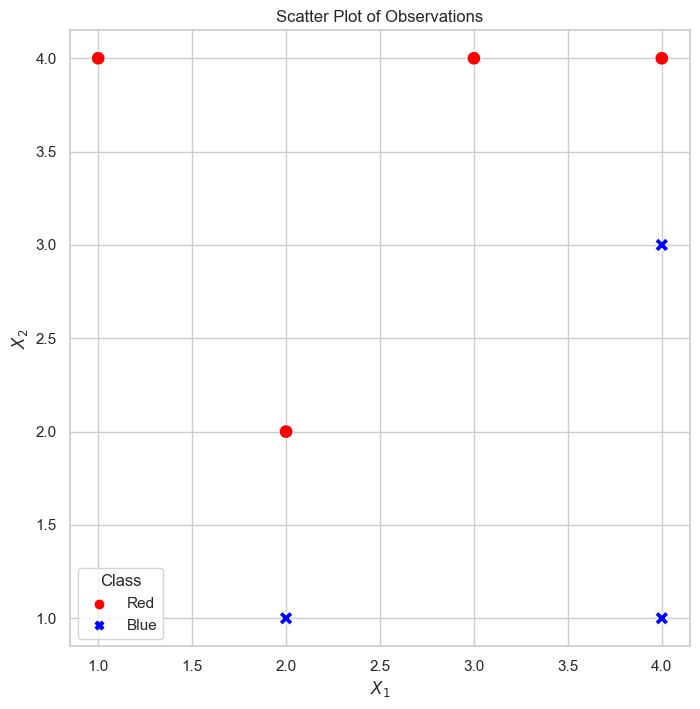

In [141]:
df = pd.DataFrame({
    'Obs.': range(1, 8),
    'X1': [3, 2, 4, 1, 2, 4, 4],
    'X2': [4, 2, 4, 4, 1, 3, 1],
    'Y': ["Red", "Red", "Red", "Red", "Blue", "Blue", "Blue"]
})
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df, x='X1', y='X2', hue='Y', style='Y', s=100, palette={'Red': 'red', 'Blue': 'blue'})
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('Scatter Plot of Observations')
plt.legend(title='Class')
plt.show()

**b** Sketch the optimal separating hyperplane, equation for hyperplane: $$X_2 - X_1 + 0.5 = 0$$

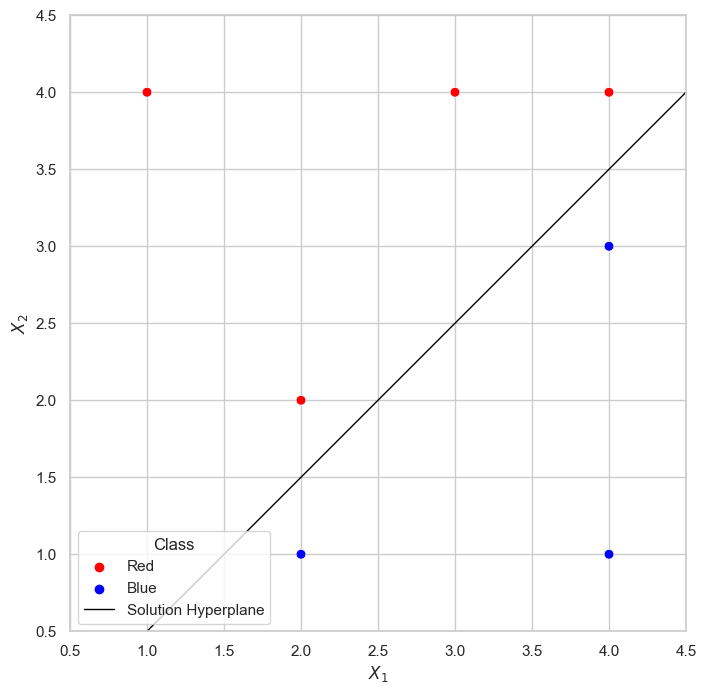

In [154]:
plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
sns.scatterplot(data=df, x='X1', y='X2', hue='Y', palette={'Red': 'red', 'Blue': 'blue'}, s=50)
# Plot the solution hyperplane with slope = 1 and intercept = -0.5
slope = 1
intercept = -0.5
x_vals = [0.5, 4.5]
y_vals = [slope * x + intercept for x in x_vals]
plt.plot(x_vals, y_vals, color='black', linestyle='-', linewidth=1, label="Solution Hyperplane")
# Set plot limits and labels
plt.xlim(0.5, 4.5)
plt.ylim(0.5, 4.5)
plt.xlabel(r'$X_1$')
plt.ylabel(r'$X_2$')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(title='Class', loc='lower left')
plt.show()

**c** As from b, the maximal margin classifier function is: $$F(x) = X_2 - X_1 - 0.5$$ Thus we classify a new observation \( X^* \) as **Red** if \( f(X^*) > 0 \) and **Blue** if \( f(X^*) <= 0 \).Therefore, $$ (\beta_0, \beta_1, \beta_2) = (0.5, -1, 1) $$

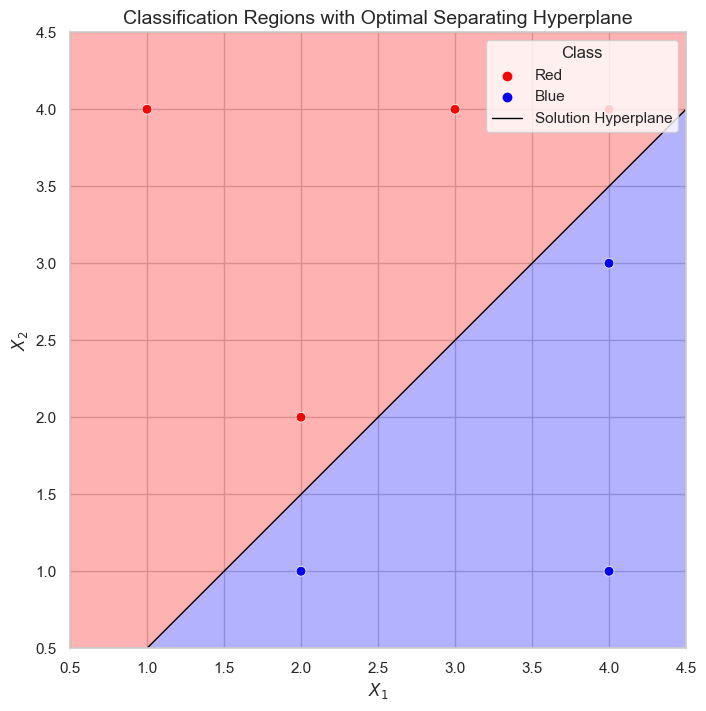

In [151]:
plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
x1_range = np.linspace(0.5, 4.5, 200)
x2_range = np.linspace(0.5, 4.5, 200)
X1, X2 = np.meshgrid(x1_range, x2_range)
Z = X2 - X1 + 0.5
# shade the regions
plt.contourf(X1, X2, Z, levels=[-np.inf, 0, np.inf], colors=["blue", "red"], alpha=0.3)
sns.scatterplot(data=df, x='X1', y='X2', hue='Y', palette={'Red': 'red', 'Blue': 'blue'}, s=50)
plt.plot(x_vals, y_vals, color='black', linestyle='-', linewidth=1, label="Solution Hyperplane")
plt.xlim(0.5, 4.5)
plt.ylim(0.5, 4.5)
plt.xlabel(r'$X_1$', fontsize=12)
plt.ylabel(r'$X_2$', fontsize=12)
plt.gca().set_aspect('equal', adjustable='box') 
plt.legend(title='Class', loc='upper right')
plt.title('Classification Regions with Optimal Separating Hyperplane', fontsize=14)
plt.show()


**d** 

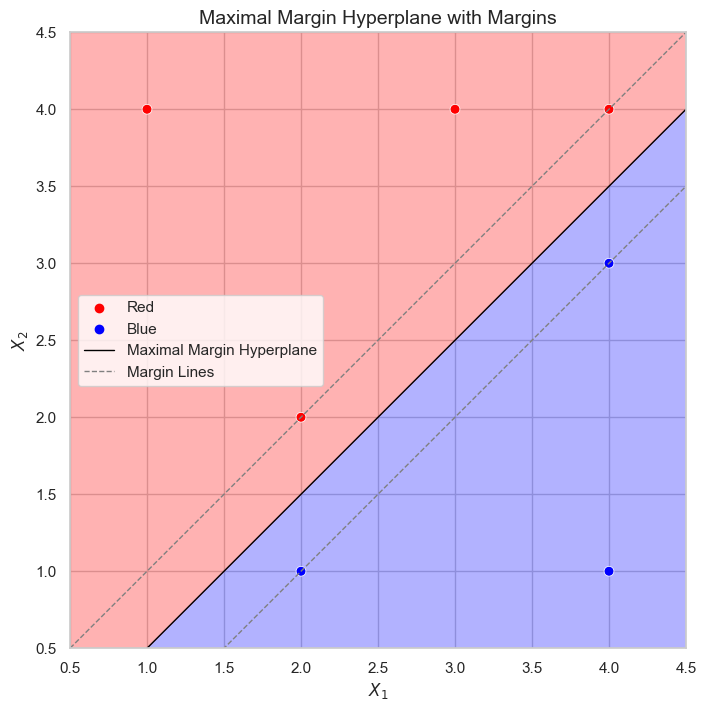

In [160]:
plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.contourf(X1, X2, Z, levels=[-np.inf, 0, np.inf], colors=["blue", "red"], alpha=0.3)
sns.scatterplot(data=df, x='X1', y='X2', hue='Y', palette={'Red': 'red', 'Blue': 'blue'}, s=50)
upper_margin_intercept = -1  # Upper margin
lower_margin_intercept = 0   # Lower margin
# Define x values as a numpy array
x_vals = np.array([0.5, 4.5])
# Calculate y values for each line based on the slope and intercepts
y_vals_main = slope * x_vals + intercept
y_vals_margin_up = slope * x_vals + upper_margin_intercept
y_vals_margin_down = slope * x_vals + lower_margin_intercept
# Plot the main hyperplane and margin lines
plt.plot(x_vals, y_vals_main, color='black', linestyle='-', linewidth=1, label="Maximal Margin Hyperplane")
plt.plot(x_vals, y_vals_margin_up, color='grey', linestyle='--', linewidth=1, label="Margin Lines")
plt.plot(x_vals, y_vals_margin_down, color='grey', linestyle='--', linewidth=1)
plt.xlim(0.5, 4.5)
plt.ylim(0.5, 4.5)
plt.xlabel(r'$X_1$', fontsize=12)
plt.ylabel(r'$X_2$', fontsize=12)
plt.gca().set_aspect('equal', adjustable='box')  # Fixed aspect ratio
plt.legend(loc='center left')
plt.title('Maximal Margin Hyperplane with Margins', fontsize=14)
plt.show()

**e** support vectors

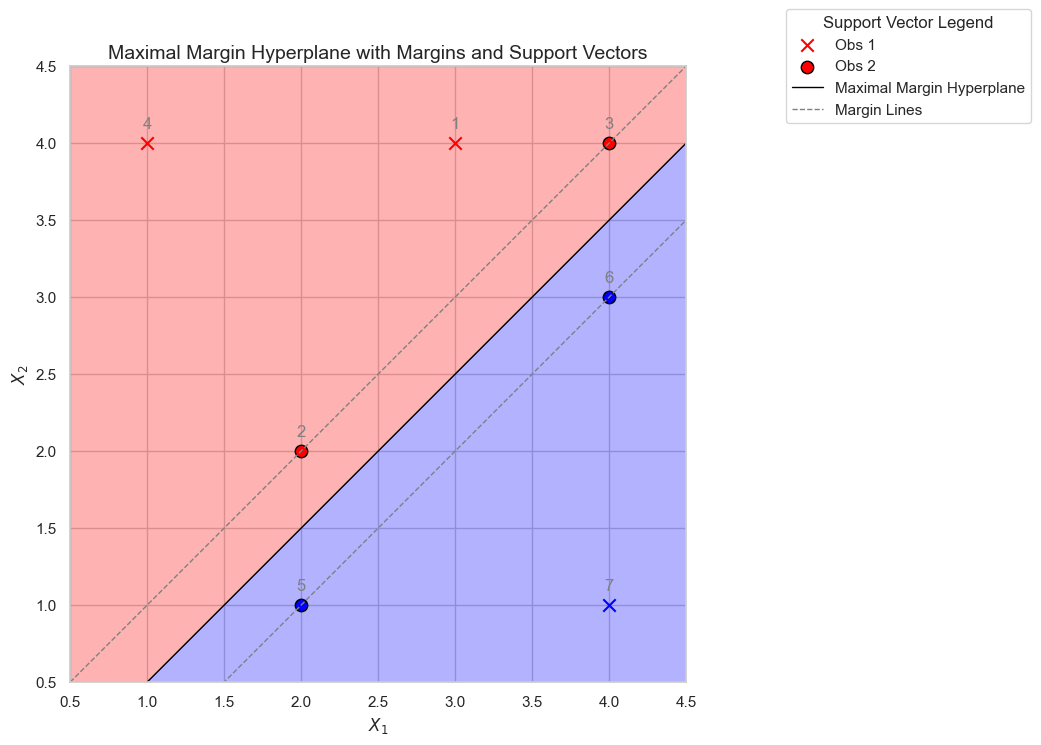

In [161]:
# Data for the main points, including support vector indicator
df = pd.DataFrame({
    'X1': [3, 2, 4, 1, 2, 4, 4],
    'X2': [4, 2, 4, 4, 1, 3, 1],
    'Y': ["Red", "Red", "Red", "Red", "Blue", "Blue", "Blue"],
    'support': ["No", "Yes", "Yes", "No", "Yes", "Yes", "No"],
    'obs': range(1, 8)  # Observation numbers
})
# Create a grid for background coloring
x1_range = np.linspace(0.5, 4.5, 200)
x2_range = np.linspace(0.5, 4.5, 200)
X1, X2 = np.meshgrid(x1_range, x2_range)
Z = X2 - X1 + 0.5
plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.contourf(X1, X2, Z, levels=[-np.inf, 0, np.inf], colors=["blue", "red"], alpha=0.3)

# Define the shapes for support vectors
support_marker = {'Yes': 'o', 'No': 'x'}
color_map = {'Red': 'red', 'Blue': 'blue'}
# Plot the data points with color for class and shape for support vector
for i, row in df.iterrows():
    plt.scatter(row['X1'], row['X2'], color=color_map[row['Y']],
                marker=support_marker[row['support']], s=80,
                edgecolor='black' if row['support'] == 'Yes' else 'none', label=f"Obs {row['obs']}" if i < 2 else "")

# Add text labels for observation numbers
for i, row in df.iterrows():
    plt.text(row['X1'], row['X2'] + 0.1, f"{row['obs']}", color='grey', ha='center')

x_vals = np.array([0.5, 4.5])
y_vals_main = slope * x_vals + intercept
y_vals_margin_up = slope * x_vals + upper_margin_intercept
y_vals_margin_down = slope * x_vals + lower_margin_intercept

# Plot the main hyperplane and margin lines
plt.plot(x_vals, y_vals_main, color='black', linestyle='-', linewidth=1, label="Maximal Margin Hyperplane")
plt.plot(x_vals, y_vals_margin_up, color='grey', linestyle='--', linewidth=1, label="Margin Lines")
plt.plot(x_vals, y_vals_margin_down, color='grey', linestyle='--', linewidth=1)
plt.xlim(0.5, 4.5)
plt.ylim(0.5, 4.5)
plt.xlabel(r'$X_1$', fontsize=12)
plt.ylabel(r'$X_2$', fontsize=12)
plt.gca().set_aspect('equal', adjustable='box') 
plt.title('Maximal Margin Hyperplane with Margins and Support Vectors', fontsize=14)
plt.legend(title="Support Vector Legend", loc="center left", bbox_to_anchor=(1.15, 1))
plt.show()


**f** From the plot above, it’s clear that observation 7 is not a support vector, so a slight movement won’t impact the optimal hyperplane. As shown in part (d), we have plotted the maximal margin hyperplane. For observation 7 to influence it, it would need to move into the margin.

**g** Non-optimal hyperplane function will follow: $$x_2 - 0.75 * x_1 - 0.3 = 0$$

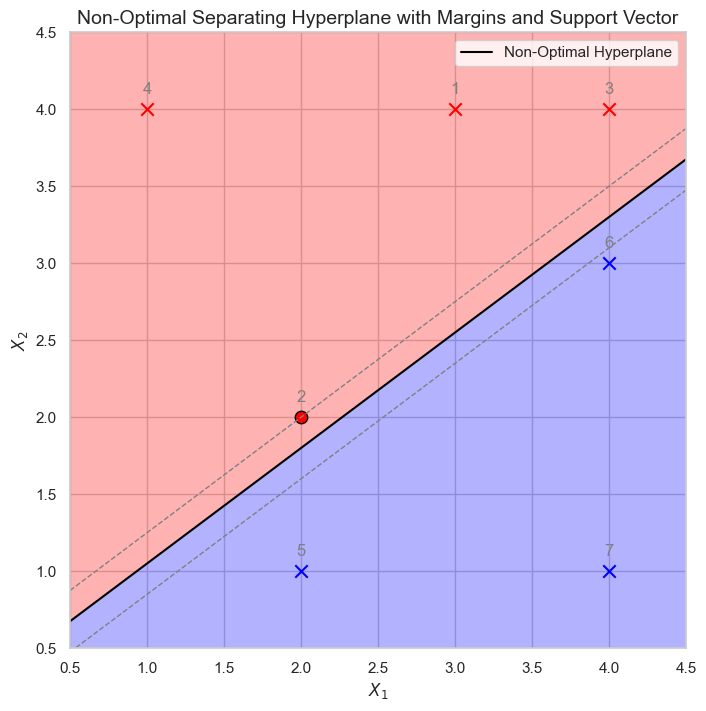

In [163]:
plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
df = pd.DataFrame({
    'X1': [3, 2, 4, 1, 2, 4, 4],
    'X2': [4, 2, 4, 4, 1, 3, 1],
    'Y': ["Red", "Red", "Red", "Red", "Blue", "Blue", "Blue"],
    'obs': range(1, 8)
})
df['support'] = np.where(df['obs'] == 2, 'Yes', 'No')

# z will be the decision boundary and differ from the previous example
Z = X2 - 0.75 * X1 - 0.3
plt.contourf(X1, X2, Z, levels=[-np.inf, 0, np.inf], colors=["blue", "red"], alpha=0.3)

# Define the shapes for support vectors
# support_marker = {'Yes': 'o', 'No': 'o'}
# color_map = {'Red': 'red', 'Blue': 'blue'}

# Plot the data points with color for class and shape for support vector
for i, row in df.iterrows():
    plt.scatter(row['X1'], row['X2'], color=color_map[row['Y']], marker=support_marker[row['support']], s=80, edgecolor='black' if row['support'] == 'Yes' else 'none')

# Add text labels for observation numbers
for i, row in df.iterrows():
    plt.text(row['X1'], row['X2'] + 0.1, f"{row['obs']}", color='grey', ha='center')

# Plot the non-optimal separating hyperplane and margin lines
slope = 0.75
intercept = 0.3
lower_margin_intercept = 0.1 
upper_margin_intercept = 0.5  

# Define x values for plotting the lines
x_vals = np.array([0.5, 4.5])
y_vals_main = slope * x_vals + intercept
y_vals_margin_down = slope * x_vals + lower_margin_intercept
y_vals_margin_up = slope * x_vals + upper_margin_intercept

# Plot the main hyperplane and margin lines
plt.plot(x_vals, y_vals_main, color='black', linestyle='-', linewidth=1.5, label="Non-Optimal Hyperplane")
plt.plot(x_vals, y_vals_margin_down, color='grey', linestyle='--', linewidth=1)
plt.plot(x_vals, y_vals_margin_up, color='grey', linestyle='--', linewidth=1)
plt.xlim(0.5, 4.5)
plt.ylim(0.5, 4.5)
plt.xlabel(r'$X_1$', fontsize=12)
plt.ylabel(r'$X_2$', fontsize=12)
plt.gca().set_aspect('equal', adjustable='box')  # Fixed aspect ratio
plt.title('Non-Optimal Separating Hyperplane with Margins and Support Vector', fontsize=14)
plt.legend()
plt.show()

**h** Draw an additional observation on the plot so that the two classes are no longer separable by a hyperplane.

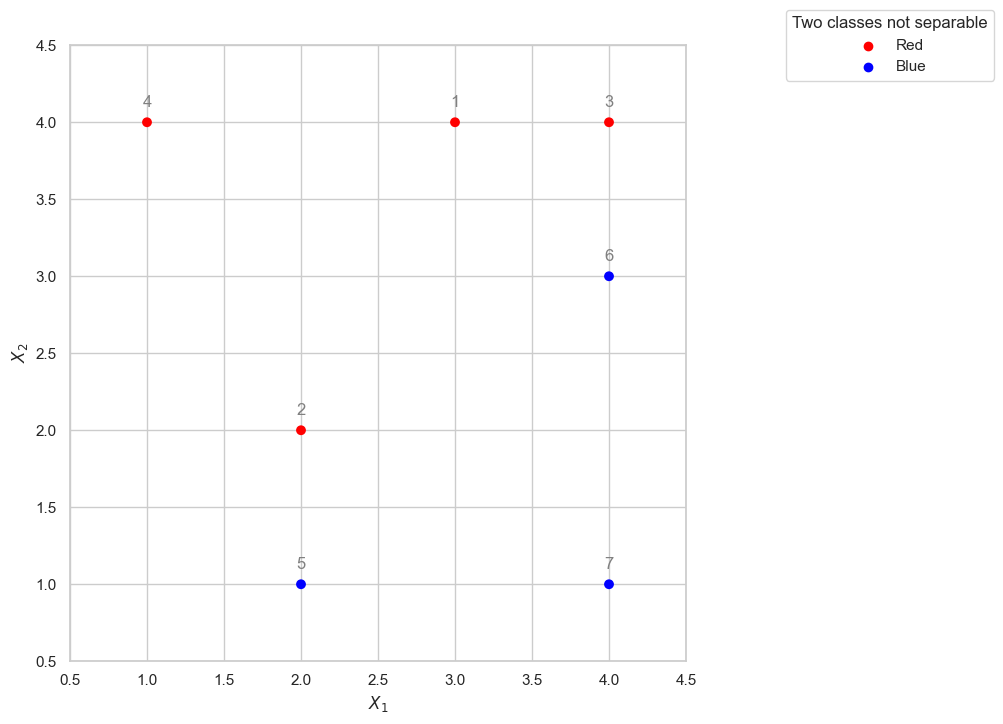

In [165]:
df = pd.DataFrame({
    'X1': [3, 2, 4, 1, 2, 4, 4],
    'X2': [4, 2, 4, 4, 1, 3, 1],
    'Y': ["Red", "Red", "Red", "Red", "Blue", "Blue", "Blue"],
    'obs': range(1, 8)
})

# Plot setup
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df, x='X1', y='X2', hue='Y', palette={'Red': 'red', 'Blue': 'blue'}, s=50, edgecolor="none")

# Add observation numbers as text labels
for i, row in df.iterrows():
    plt.text(row['X1'], row['X2'] + 0.1, str(row['obs']), color='grey', ha='center')

# Set axis limits, labels, and aspect ratio
plt.xlim(0.5, 4.5)
plt.ylim(0.5, 4.5)
plt.xlabel(r'$X_1$')
plt.ylabel(r'$X_2$')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.legend(title="Two classes not separable", loc="center left", bbox_to_anchor=(1.15, 1))
plt.show()

### Citations 


- https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html
- https://scikit-learn.org/stable/modules/impute.html#imputation-of-missing-values
- https://www.statsmodels.org/stable/imputation.html 
- https://scikit-learn.org/stable/modules/impute.html
- https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://pmc.ncbi.nlm.nih.gov/articles/PMC3224215/
- https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
- https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html

### chatgpt: prompt and reponses 

prompt: I want to write analysis function that can construct cnfusin matrix, finds accyuracy, finds error and have option to account is_xgboost=bool, and also plot ROC curve. give me syntax 

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def analysis(y_true, y_pred, y_proba, title, is_xgboost=False):
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(f'Confusion Matrix for {title}:\n{conf_matrix}\n')

    # Accuracy and Error
    accuracy = round(accuracy_score(y_true, y_pred), 5)
    error = round(1 - accuracy, 5)
    print(f'Accuracy: {accuracy}')
    print(f'Error: {error}')
    
    # ROC AUC Score (For XGBoost only, if specified)
    if is_xgboost:
        roc_auc = round(roc_auc_score(y_true, y_pred), 5)
        print(f'ROC AUC Score (XGBoost): {roc_auc}')
    
    # Plot ROC Curve
    y_pred_proba = y_proba[:, 1] if y_proba.shape[1] > 1 else y_proba  # Select the probability for the positive class
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC Curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC AUC: {round(roc_auc, 5)}')
    plt.plot([0, 1], [0, 1], '--', color='gray')  # Diagonal line for random guessing
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {title}")
    plt.legend(loc="lower right")
    plt.show()
    
    # Return summary data
    data = {
        'conf_matrix': conf_matrix,
        'accuracy': accuracy,
        'error': error,
        'roc_auc': roc_auc
    }
    if is_xgboost:
        data['roc_auc_xgboost'] = roc_auc
    return data


prompt: given this reference find optimal hyper-parameter for scaling. https://pmc.ncbi.nlm.nih.gov/articles/PMC3224215/

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Example parameter grid for scaling and hyperparameters
param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler()],
    'classifier__reg_alpha': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
}

# Setting up the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # placeholder scaler, will be tuned in param_grid
    ('classifier', XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss'))
])

# Cross-validation with GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(df_train_x_imputed, df_train_y)

# Best parameters found
best_scaler = grid_search.best_params_['scaler']
best_reg_alpha = grid_search.best_params_['classifier__reg_alpha']
best_score = grid_search.best_score_

print(f"The best scaling method: {best_scaler}")
print(f"The best reg_alpha: {best_reg_alpha}")
print(f"Best cross-validation accuracy: {best_score}")


prompt: for balancing data, give me syntax with it using randomforestclassifier()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier with class_weight='balanced'
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(x_train, y_train)

prompt: after scaling data points with hyperparameter (reg_alpha) give me syntax to tune and train using xgbclassifier and gridsearchcv to find best alpha and accuracy of cv. 

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assuming you already have your data in df_train_x and df_train_y

# Step 1: Scale the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(df_train_x)  # Scale training data
x_test_scaled = scaler.transform(df_test_x)        # Scale test data (for later use)

# Step 2: Define the parameter grid for `reg_alpha`
param_grid = {
    'reg_alpha': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]  # Example values; adjust as needed
}

# Step 3: Initialize the XGBClassifier with base parameters
xgb = XGBClassifier(objective='binary:logistic', colsample_bytree=0.3, 
                    learning_rate=0.1, max_depth=5, use_label_encoder=False, random_state=42)

# Step 4: Set up GridSearchCV with cross-validation (e.g., 5-fold)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                           scoring='accuracy', cv=KFold(n_splits=5, shuffle=True, random_state=42), 
                           n_jobs=-1, verbose=1)

# Step 5: Fit GridSearchCV on the scaled training data to find the best `reg_alpha`
grid_search.fit(x_train_scaled, df_train_y)

# Step 6: Extract the best parameters and score
best_alpha = grid_search.best_params_['reg_alpha']
best_cv_accuracy = grid_search.best_score_

print(f"The best alpha: {best_alpha}")
print(f"Best CV training accuracy: {best_cv_accuracy:.5f}")

# Step 7: Train the final model with the best `reg_alpha`
final_model = XGBClassifier(objective='binary:logistic', reg_alpha=best_alpha, colsample_bytree=0.3, 
                            learning_rate=0.1, max_depth=5, use_label_encoder=False, random_state=42)
final_model.fit(x_train_scaled, df_train_y)

prompt: reference this https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html, how can we shade regions?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range for X_1 and X_2
x1_vals = np.linspace(0, 5, 200)
x2_vals = np.linspace(0, 5, 200)

# Create a grid of (X_1, X_2) points
X1, X2 = np.meshgrid(x1_vals, x2_vals)

# Define the function based on the hyperplane equation
# f(X_1, X_2) > 0 for one region, < 0 for the other region
Z = X2 - X1 + 0.5

# Plot the contourf to shade regions
plt.contourf(X1, X2, Z, levels=[-np.inf, 0, np.inf], colors=['lightblue', 'lightcoral'], alpha=0.3)

# Plot the hyperplane line where Z = 0 (i.e., X_2 = X_1 - 0.5)
plt.contour(X1, X2, Z, levels=[0], colors='black', linewidths=2, linestyles='-')

# Add labels and title
plt.xlabel(r'$X_1$')
plt.ylabel(r'$X_2$')
plt.title('Shaded Regions Based on Hyperplane')

# Set plot limits
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.grid(True)

# Show the plot
plt.show()
